Fréquence d’échantillonnage: 11025 Hz
Taille shape: (2338149, 2)


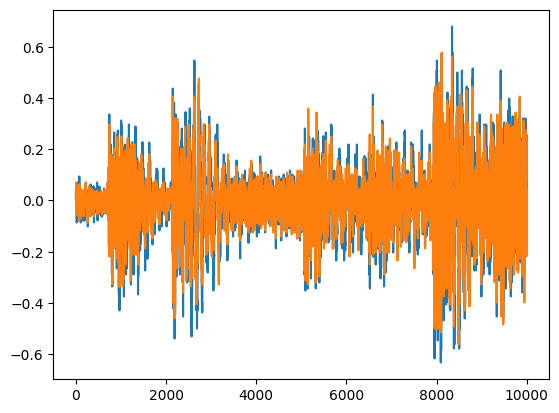

In [56]:
import numpy
import scipy
import matplotlib.pyplot as plt
import soundfile
import os
import subprocess

chemin_son = "Son.wav"

signal, fréquence_échantillonnage = soundfile.read(chemin_son)

print(f"Fréquence d’échantillonnage: {fréquence_échantillonnage} Hz")
print(f"Taille shape: {signal.shape}")

plt.plot(signal[200000:210000])

<h1 align="center">🎵 FLAC 🎵</h1>

Présenté par Alix ANNERAUD et Haijiao YU

# ✅ Caractéristiques

- **Type de données**: 🎵
- **Extension du fichier**: `.flac`
- **Développé par**: Xiph.Org Foundation
- **Première version**: 20 juillet 2001
- **Échantillonnage**: variable
- **Compression**: ✅
- **Perte de données**: ❌ 


Le **Free Lossless Audio Codec** (FLAC) est un codec audio sans perte de données.

Il a été développé par la Xiph.Org Foundation et sa première version a été publiée le 20 juillet 2001.

Contrairement à d'autres codecs audio tels que MP3 et AAC, FLAC ne supprime aucune donnée audio lors de la compression. Cela signifie que la qualité audio est conservée à 100% et que le fichier audio compressé , une fois décompressé, est identique à l'original.

FLAC est un format audio populaire pour les audiophiles et les professionnels de l'audio en raison de sa qualité audio sans perte et de sa compatibilité avec de nombreux lecteurs multimédias et appareils audio.

Il supporte des échantillonnages variables et peut compresser des fichiers audio jusqu'à 50 à 70% de leur taille d'origine.

# 📈 Numérisation du signal 

```mermaid
flowchart LR
    Signal_analogique[Signal analogique]
    Signal_numérique[Signal numérique]
    Signal_encodé[Signal encodé]

    Signal_analogique -->|Echantillonnage| Signal_numérique
    Signal_numérique -->|Encodage| Signal_encodé

    Signal_encodé -->|Décodage| Signal_numérique
    Signal_numérique -->|Reconstruction| Signal_analogique
```

- **Signal analogique**: Signal sonore continu dans le temps (exemple : vinyle).
- **Signal numérique**: Signal discret en temps et en amplitude (exemple : fichier WAV).
- **Signal encodé**: Signal numérique compressé (exemple : fichier FLAC, MP3, AAC, etc.).

Afin de comprendre le fonctionnement du FLAC, il est important de comprendre le principe général de la numérisation du signal.

Initialement, le signal sonore est analogique c'est à dire qu'il est continu dans le temps et dans l'amplitude.

Tout d'abord, nous allons en faire une acquisition numérique en le mesurant à intervalles réguliers. C'est ce qu'on appelle l'échantillonnage.

Ensuite, le signal numérique est encodé pour être stocké sur un support numérique. Qu'un codec audio est appliqué. Le codec peut proposer une compression ou non, et cette compression peut être avec ou sans perte. 

Comme expliqué précédemment, le FLAC est un codec audio qui propose une compression sans perte.

# 🔄 Principe d'encodage

Nous allons maintenant étudier le principe d'encodage du FLAC étape par étape.

## 🔪 Division en blocs


```mermaid
graph TB
    Signal_audio[Signal audio]

    Signal_audio -->Canal_1[Canal 1]
    Signal_audio -->Canal_2[Canal 2]
    Signal_audio -->Canal_...[Canal ...]

    Canal_1 -->Bloc_11[Bloc 1]
    Canal_1 -->Bloc_12[Bloc 2]
    Canal_1 -->Bloc_1...[Bloc ...]

    Canal_2 -->Bloc_21[Bloc 1]
    Canal_2 -->Bloc_22[Bloc 2]
    Canal_2 -->Bloc_2...[Bloc ...]

    Canal_... -->Bloc_...1[Bloc 1]
    Canal_... -->Bloc_...2[Bloc 2]
    Canal_... -->Bloc_......[Bloc ...]
```

Tout d'abord, le signal audio numérique est divisé en blocs contenant tous un nombre identique d'échantillons pour chaque canal audio.

La taille de ces blocs est généralement de 4096 échantillons par canal.

Pour rappel, un échantillon est une valeur numérique représentant l'amplitude du signal audio à un instant donné et peut être encodé sur plusieurs bits (8, 16, 24, 32 bits, etc.).

Ces blocs seront par la suite traités de manière indépendante. Ainsi, chaque blocs possédera ses propres métadonnées de compressions. Les métadonnées de compression sont par exemple le dictionnaire de prédiction utilisé pour la compression d'Huffman.

Dans le cas ou un signal audio ne se divise pas parfaitement en blocs, le dernier bloc sera complété par des échantillons nuls (c'est ce qu'on appelle le remplissage, ou padding en anglais).

In [57]:
nombre_échantillons, nombre_canaux = signal.shape

print(f"Durée: {int(nombre_échantillons / fréquence_échantillonnage)} secondes")
print(f"Nombre de canaux: {nombre_canaux}")
print(f"Fréquence d’échantillonnage: {fréquence_échantillonnage} Hz")
print(f"Encodage: {signal.dtype}")
print(f"Nombre d’échantillons par canal: {nombre_échantillons}")

Durée: 212 secondes
Nombre de canaux: 2
Fréquence d’échantillonnage: 11025 Hz
Encodage: float64
Nombre d’échantillons par canal: 2338149


Tout d'abord, laissez moi vous présenter notre cobaye:

- C'est une musique qui dure X secondes
- Composé de 2 canaux audio (c'est normal pour une musique stéréo) 
- Échantillonné à X Hz.
- Les échantillons sont codés sur 16 bits, cependant, la librairie python que nous utilisons pour lire le fichier audio nous renvoie une matrice numpy de flottants sur 64 bits où les valeurs sont comprises entre -1 et 1.
- Au total nous avons X échantillons par canal.

In [58]:
def division_par_bloc(signal, taille_bloc):   
    nombre_canaux = signal.shape[1]
    
    nombre_blocs = (len(signal) + taille_bloc - 1) // taille_bloc
    blocs = numpy.zeros((nombre_blocs, taille_bloc, nombre_canaux))
    
    for i in range(nombre_blocs):
        début = i * taille_bloc
        fin = min(début + taille_bloc, len(signal))
        blocs[i, :fin - début] = signal[début:fin]
        
    return blocs

taille_bloc = 4096
blocs = division_par_bloc(signal, taille_bloc)

nombre_blocs, taille_blocs, nombre_canaux = blocs.shape

print(f"Nombre de blocs: {nombre_blocs}")
print(f"Taille des blocs: {taille_bloc}")
print(f"Nombre de canaux: {nombre_canaux}")

Nombre de blocs: 571
Taille des blocs: 4096
Nombre de canaux: 2


Nous allons maintenant diviser notre signal audio en blocs de 4096 échantillons par canal.

Ce code est équivalent à un reshape, cependant, cela n'était pas vraiment possible dans notre cas car les les échantillons sont stockés dans des tableaux qui sont eux même stockés dans un tableau. Il s'agit d'une convention, je ne sais pas pourquoi mais c'est comme ça.

L'inverse aurait été plus simple.

## 🔍 Décorrélation inter-canal (optionnel)

$$
\begin{align*}
    x_\text{central} &= \frac{x_\text{gauche} + x_\text{droite}}{2} \\
    x_\text{latéral} &= x_\text{gauche} - x_\text{droite}
\end{align*}
$$

Réduit la redondance

Nous allons maintenant procéder à la décorrélation inter-canal. 

Le principe fondamental de la compression est l'élimination de la redondance. Ainsi, lors de cette première étape nous allons utiliser le fait que dans un signal audio stéréo, les deux canaux sont très similaires.

Ainsi, dans la partie commune (c'est à dire la moyenne) aux deux canaux, nous allons stocker dans le canal central tandis que la différence entre les deux canaux sera stockée dans le canal latéral.

Sachant que dans un signal audio stéréo, les deux canaux sont très similaires, le canal central sera donc proche aux signaux initiaux, tandis que le canal latéral sera en moyenne très faible.

Cette faible amplitude sera très facilement compressée par la suite car on aura beaucoup de répétitions de signes.

Il s'agit d'une étape optionnelle vu quelle n'est utile que si le signal audio est stéréo. Donc cela ne fonctionne pas dans le cas d'un signal mono. Dans le cas d'un signal 5.1/7.1, cette approche est également pertinente mais il faudra adapter les formules.

In [59]:
def décorréler(signal):
    signal_décorrélé = numpy.zeros(signal.shape)
        
    signal_décorrélé[:, :, 0] = signal.mean(axis=2)
    signal_décorrélé[:, :, 1] = signal[:, :, 1] - signal[:, :, 0]
    
    return signal_décorrélé

signal_décorrélé = décorréler(blocs)

print(f"Taille shape: {blocs.shape}")

print(f"Taille shape: {signal_décorrélé.shape}")

print(signal_décorrélé[2, :, 0].shape)
print(signal_décorrélé[2, :, 1].shape)


Taille shape: (571, 4096, 2)
Taille shape: (571, 4096, 2)
(4096,)
(4096,)


In [60]:
%%capture out

bloc = 11

Axes, Figures = plt.subplots(2, 1)

minimum = min(blocs[bloc, :, 0].min(), blocs[bloc, :, 1].min())
maximum = max(blocs[bloc, :, 0].max(), blocs[bloc, :, 1].max())

Figures[0].set_title("Signal original")
Figures[0].plot(blocs[bloc, :, 0], label=f"Gauche ($\mu = {blocs[bloc, :, 0].mean():.2f}$, $\sigma = {blocs[bloc, :, 0].std():.2f}$)")
Figures[0].plot(blocs[bloc, :, 1], label=f"Droit ($\mu = {blocs[bloc, :, 1].mean():.2f}$), $\sigma = {blocs[bloc, :, 1].std():.2f}$")
Figures[0].set_ylim(minimum, maximum)
Figures[0].legend()

Figures[1].set_title("Signal décorrélé")
Figures[1].plot(signal_décorrélé[bloc, :, 0], label=f"Central ($\mu = {signal_décorrélé[bloc, :, 0].mean():.2f}$, $\sigma = {signal_décorrélé[bloc, :, 0].std():.2f}$)")
Figures[1].plot(signal_décorrélé[bloc, :, 1], label=f"Latéral ($\mu = {signal_décorrélé[bloc, :, 1].mean():.2f}$, $\sigma = {signal_décorrélé[bloc, :, 1].std():.2f}$)")
Figures[1].set_ylim(minimum, maximum)
Figures[1].legend()

plt.tight_layout()
plt.show()

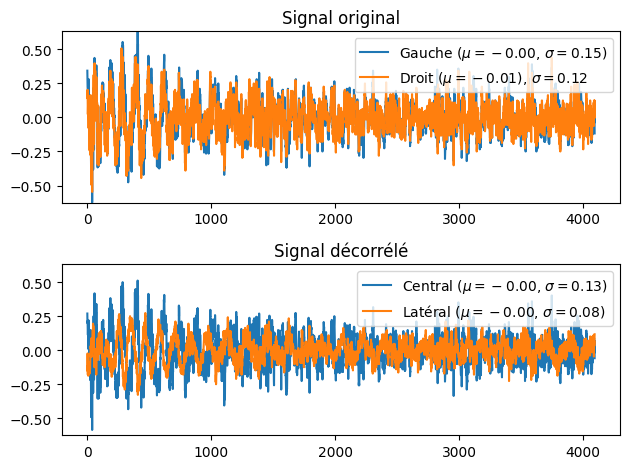

In [61]:
out()

On constate que l'amplitude du signal latéral est souvent plus faible que celle des signaux d'origine.

## 📐 Modélisation

On cherche à approximer le signal avec une fonction:

$$
x_n = f(x_{n-1}, x_{n-2}, \ldots, x_{n-p}) + e_n
$$

Où:
- $x_n$ : échantillon à l'instant $n$
- $f$ : fonction de prédiction
- $e_n$ : les résidus
- $p$ : ordre de la prédiction

On cherche : 

$$
\min_{f} \sum_{n=1}^N (x_n - f(x_{n-1}, x_{n-2}, \ldots, x_{n-p}))^2
$$

Nous allons maintenant chercher à modéliser notre signal audio.

La modélisation sera une approximation du signal audio par une fonction. Cette fonction prendra en entrée les $p$ échantillons précédents, $p$ étant l'ordre de la prédiction, et renverra une valeur qui sera la prédiction de l'échantillon suivant.

Le but est de trouver la fonction $f$ qui minimise l'erreur quadratique moyenne entre les échantillons réels et les échantillons prédits.

Au final, on se retrouvera avec les $p$ coefficients de la fonction $f$ ainsi que les résidus $e_n$ qui seront de très faible amplitude et seront donc très facilement compressibles.

Le but étant de trouver la fonction $f$ qui minimisent $e_n$ afin de réduire la quantité d'information à stocker. Pour cela, on dispose de deux méthodes.

### 📈 Ajustement de polynômes simples

On a $f$ qui est un polynôme de degré $p$:

$$f(x) = a_0 + a_1 x_{n-1} + a_2 x_{n-2} + \ldots + a_p x_{n-p}$$

La première méthode pour approximer le signal est l'ajustement de polynômes simples.

$f$ est alors un polynôme de degré $p$, où les $p$ coefficients $a_0, a_1, \ldots, a_p$ permettent de prévoir l'échantillon suivant en fonction des $p$ échantillons précédents.

Nous cherchons à trouver ces coefficients $a_0, a_1, \ldots, a_p$ qui minimisent l'erreur quadratique moyenne afin d'avoir les résidus les plus faibles possibles.

$$
\begin{align*}
    a_0 &= \frac{\sum x_n}{N} \\
    a_1 &= \frac{\sum x_n x_{n-1}}{\sum x_{n-1}^2} \\
    a_2 &= \frac{\sum x_n x_{n-2}}{\sum x_{n-2}^2} \\
    &\vdots \\
    a_p &= \frac{\sum x_n x_{n-p}}{\sum x_{n-p}^2}
\end{align*}
$$

Voici les formules pour calculer les coefficients $a_0, a_1, \ldots, a_p$. Ces formules sont dérivées de la minimisation de l'erreur quadratique moyenne.

Cette méthode est simple et efficace lors de l'encodage mais elle ne permet pas de modéliser des signaux complexes efficacement, on se retrouve donc avec des résidus plus important que la méthode suivante, ce qui nécessite de stocker plus d'informations.

### 🔮 Codage prédictif linéaire

On a :

$$f(x) = \sum_{i=1}^p a_i x_{n-i}$$

On peut représenter les résidus $e_n$ comme un processus AR(p) :

$$
    R_i = \sum_{j=1}^{p} a_j R_{i-j}
$$

Où :
- $R_i$ est la fonction d'autocorrélation
- $a_j$ sont les coefficients de prédiction
- $p$ est l'ordre de prédiction

Résolu par la méthode de **Levinson-Durbin**.

L'autre méthode pour approximer le signal est le codage prédictif linéaire.

Dans ce cas, la fonction $f$ est une somme pondérée des $p$ échantillons précédents.

Comme étudié en traitement du signal aléatoire, on peut représenter les résidus $e_n$ comme un processus AR(p) où $R_i$ est la fonction d'auto-corrélation et $a_j$ sont les coefficients de prédiction.

Cette méthode est beaucoup plus lourde en terme de calcul car elle nécessite de calculer la matrice d'auto-corrélation et de résoudre un système d'équations linéaires. Et même si on ne traite qu'un bloc à la fois, cela reste une opération coûteuse en terme de calcul car elle est de complexité $O(np^2)$.

Cependant, elle permet de modéliser des signaux complexes de manière plus efficace et donc de réduire l'amplitude des résidus.

In [62]:
def codage_prédictif_linéaire_bloc(signal, ordre):
    autocorrelation = scipy.signal.correlate(signal, signal, mode="full")
    autocorrelation = autocorrelation[len(autocorrelation) // 2 :]

    R = scipy.linalg.toeplitz(autocorrelation[:ordre])
    r = autocorrelation[1 : ordre + 1]

    return scipy.linalg.solve_toeplitz((R[:, 0], R[0, :]), r)

In [63]:
def codage_prédictif_linéaire(signal, ordre):
    nombre_blocs, taille_bloc, nombre_canaux = signal.shape
    coefficients = numpy.zeros((nombre_blocs, nombre_canaux, ordre))

    for index_bloc in range(nombre_blocs):
        for index_canal in range(nombre_canaux):
            bloc = signal[index_bloc, :, index_canal]
            
            coefficients[index_bloc, index_canal, :] = codage_prédictif_linéaire_bloc(bloc, ordre)

    return coefficients

In [64]:
def prediction_linéaire(signal, coefficients):
    nombre_blocs, taille_bloc, nombre_canaux = signal.shape
    signal_prédit = numpy.zeros(signal.shape)

    for index_bloc in range(nombre_blocs):
        for index_canal in range(nombre_canaux):
            bloc = signal[index_bloc, :, index_canal]
            
            signal_prédit[index_bloc, :, index_canal] = scipy.signal.lfilter(
                [1],
                numpy.concatenate(([1], -coefficients[index_bloc, index_canal])),
                bloc,
            )

    return signal_prédit

In [65]:
ordre = 9

coefficients = codage_prédictif_linéaire(signal_décorrélé, ordre)
prédictions = prediction_linéaire(signal_décorrélé, coefficients)
résidus = signal_décorrélé - prédictions


In [ ]:
%%capture out

bloc = 10

Axes, Figures = plt.subplots(2, 1)

Figures[0].set_title("Du signal décorrélé")
Figures[0].hist(signal_décorrélé[bloc, :, 0])

D, p_value = scipy.stats.kstest(signal_décorrélé[bloc, :, 0], "laplace", args=(
    signal_décorrélé[bloc, :, 0].mean(),
    signal_décorrélé[bloc, :, 0].std(ddof=1)/numpy.sqrt(2)
))

print(f"p-value: {p_value}")

Figures[1].set_title("Distribution des résidus")
Figures[1].hist(résidus[bloc, :, 0])

D, p_value = scipy.stats.kstest(résidus[bloc, :, 0], "laplace", args=(
    résidus[bloc, :, 0].mean(),
    résidus[bloc, :, 0].std(ddof=1)/numpy.sqrt(2)
))

print(f"p-value: {p_value}")


plt.tight_layout()

p-value: 2.667403715538888e-17
p-value: 1.5676417329462423e-15


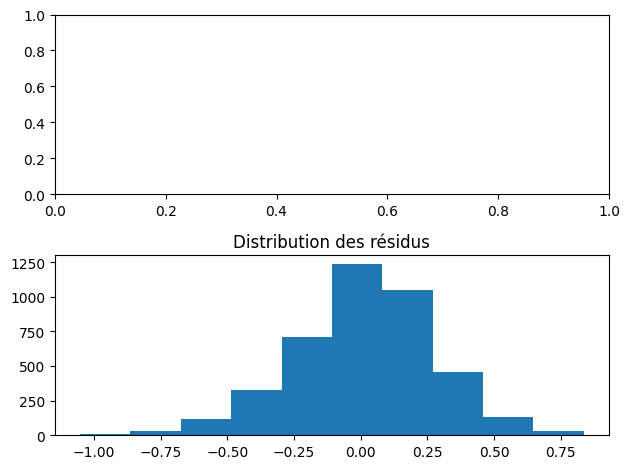

In [67]:
out()


## 🗜️ Compression

Les résidus sont des nombres entiers très petits (peu de bits significatifs)

Codage à longueur variable :

- **Golomb-Rice**
    - Rapide à encoder et à décoder.
    - Efficace pour les distributions de symboles géométriques ou exponentielles.
- **Huffman**
    - Plus lent à encoder et à décoder.
    - Efficace pour les distributions de symboles non uniformes.

Nous avons maintenant les coefficients de prédiction $a_0, a_1, \ldots, a_p$ ainsi que les résidus $e_n$.

Nous allons maintenant chercher à compresser ces résidus. Il pourrait sembler intéressant de compresser les coefficients de prédiction mais cela ne serait pas très efficace car ils s'agit de nombres flottants aux valeurs très variables.

Comme expliqué précédemment, les résidus sont de très faible amplitude et sont donc très compressibles.

Pour cela, nous allons utiliser un codage à longueur variable. Les deux méthodes les plus utilisées sont le codage de Golomb-Rice et le codage de Huffman.

### 🌳 Codage d'Huffman

Pour rappel, pour coder des données:

1. Calculer la fréquence d'apparition de chaque symbole.
2. Création d'un arbre binaire.
3. On calcule le dictionnaire de traduction.
4. On traduit les signaux en binaire.
5. On stocke la traduction et l'arbre binaire.

Nous n'allons pas rentrer dans les détails du codage de Huffman vu que nous l'avons déjà vu en Algo et revu en TI, cependant, voici pour rappels sont principe général:
1. On calcule la fréquence d'apparition de chaque symbole que l'on trie par ordre croissant.
2. On crée un arbre binaire où les symboles les plus fréquents sont les plus proches de la racine.
3. On calcule le dictionnaire de traduction qui est une table de correspondance entre les symboles et leur code binaire provenant de l'arbre binaire.
4. On traduit les signaux en binaire en utilisant le dictionnaire de traduction.
5. On stocke la traduction et l'arbre binaire dans le fichier compressé.

Cette méthode est très efficace pour compresser des données avec des distributions de symboles non uniformes, cepandant, elle est plus lente à encoder et à décoder que le codage de Golomb-Rice.

### 🍚 Codage de Golomb-Rice

Pour coder un nombre $N$ avec un paramètre $k$:

1. Calculer le quotient $q$ et le reste $r$ : $N = q \times 2^k + r$.
2. Coder le quotient $q$ en unaire ($q$ fois le bit 1 suivi du bit 0): $q_\text{unaire} = 1^q 0$.
3. Coder le reste $r$ en binaire sur $k$ bits: $r_\text{binaire} = \text{binaire}(r, k)$
4. Combiner les deux parties: $\text{Résultat final} = q_\text{unaire} \, r_\text{binaire}$

Le codage de Golomb-Rice est une méthode de codage à longueur variable qui est très efficace pour les distributions de symboles géométriques ou exponentielles.

Pour coder un nombre $N$ avec un paramètre $k$ (où $k$ est un entier non négatif):

1. On commence par calculer le quotient $q$ et le reste $r$ de la division euclidienne de $N$ par $2^k$.
2. On code le quotient $q$ en unaire, c'est à dire que l'on écrit $q$ fois le bit 1 suivi du bit 0.
3. On code le reste $r$ en binaire sur $k$ bits.
4. On combine les deux parties pour obtenir le résultat final.
5. On stocke le paramètre $k$ qui est généralement fixé à une valeur donnée.
6. On stocke le résultat final.

Le choix optimal de $k$ :

$$
k_\text{optimal} = \frac{\log_2 \left( 2 - \frac{V}{I} \right)}{\log_2 \left( 1 - \frac{V}{I} \right)}
$$

Où:
- $V$ est la quantité de valeurs.
- $I$ est la taille de l'intervalle.

In [68]:
def encoder_golomb_rice(N, k):
    d = 2 ** k
    quotient = N // d   # Calcul du quotient
    reste = N % d    # Calcul du reste
    
    quotient_unaire = '1' * quotient + '0'         # Encodage du quotient en unaire
    reste_binaire = format(reste, f'0{k}b')  # Encodage du reste en binaire
    
    return quotient_unaire + reste_binaire   # Concaténation des deux encodages

for i in range(10):
    print(f'{i:2} -> {encoder_golomb_rice(i, 3)}')

 0 -> 0000
 1 -> 0001
 2 -> 0010
 3 -> 0011
 4 -> 0100
 5 -> 0101
 6 -> 0110
 7 -> 0111
 8 -> 10000
 9 -> 10001


In [ ]:
def compression_signal(residus, k):
    flux_compresse = ""
    
    nombre_blocs, taille_bloc, nombre_canaux = residus.shape
    for b in range(nombre_blocs):
        for c in range(nombre_canaux):
            for i in range(taille_bloc):
                N = residus[b,i,c]
                
                valeur_encodee = encoder_golomb_rice(N, k)
                flux_compresse += valeur_encodee
    
    return flux_compresse
#print(f'le flux compressé obtenu est: {compression_signal(résidus, 3)}')
matrice = numpy.random.randint(1,10,size=(3,3,2))

print(matrice)
print(f'le flux compressé obtenu est: {compression_signal(matrice, 3)}')

# 🔄 Principe de décodage du FLAC

Pour décoder un fichier FLAC, il faut :

1. Lire les métadonnées

2. Décoder les résidus

3. Appliquer la prédiction inverse

4. Reconstruire le signal audio

### Lire les métadonnées & Décoder les résidus

1. On lit les 1 consécutifs du code jusqu'à rencontrer un 0 pour déterminer le **quotient $q$**.
2. À partir de la partie restante du code, on lit un nombre binaire de longueur fixe $k$ pour déterminer le **reste $q$**.
3. On reconstitut la valeur originale à l'aide de la formule :
$$
N = q * 2^k + r
$$

In [ ]:
def decoder_golomb_rice(code, k):
    quotient = 0
    while code[quotient] == '1': 
        quotient += 1
    
    reste_commence = quotient + 1
    reste = int(code[reste_commence:], 2)  

    d = 2**k
    N = quotient * d + reste

    return N

In [ ]:
def decoder_golomb_rice_stream(flux_code, k):
    valeurs_decodees = []
    i = 0

    while i < len(flux_code):
        quotient = 0 # Extraire la partie du quotient q
        
        while i < len(flux_code) and flux_code[i] == '1':
            quotient += 1 # On compte le nombre de '1' consécutifs
            i += 1
        i += 1 # Passer au quotient

        reste = int(flux_code[i:i+k], 2) # Extraire la partie du reste r, on le convert en entier
        i += k # Avancer de k bits pour passer au deuxième
        
        d = 2**k
        N = quotient * d + reste # Calculer la valeur originale N
        valeurs_decodees.append(N)
    
    return valeurs_decodees

In [ ]:
def convert_a_matrice(flux_code, k, shape):
    decode = decoder_golomb_rice_stream(flux_code, k) 
    nombre_blocs, taille_bloc, nombre_canaux = shape
    matrice_decodee = numpy.zeros(shape, dtype=int)  # Créer une matrice vide pour stocker les résultats
    i = 0  # Position dans le flux compressé

    for b in range(nombre_blocs):
        for c in range(nombre_canaux):
            for n in range(taille_bloc):
                matrice_decodee[b, n, c] = decode[i]
                i += 1 
    
    return matrice_decodee

In [ ]:
flux_code = compression_signal(matrice, 3)
print(flux_code)
matrice_decodee = convert_a_matrice(flux_code, 3, matrice.shape)
print(f'la matrice décodée obtenue est:\n {matrice_decodee}')
print(f'la matrice originale est:\n {matrice}')

### Appliquer la prédiciton inverse 

Nous vous rappelons d'abord la formule de prédiciton que nous avons appliqué:

$$f(x) = \sum_{i=1}^p a_i x_{n-i} + e_n$$

où:
- $x_n$: échantillon à l'instant $n$.
- $a_i$: coefficients de prédiction.
- $x_{n-i}$: échantillons précédents déjà reconstruits.
- $e_n$: résidu à l’instant $n$, obtenu après compression.
- $p$ : ordre de la prédiction.


Nous réalisons la reconstruction pour chaque bloc, chaque canal et chaque échantillon:
- Étape 1: Si $n$ < $p$, donc $x_n$ = $e_n$.
- Étape 2: Sinon, calculer la prédiciton:
$$prédiction = \sum_{i=1}^p a_i x_{n-i}$$
- Étape 3: Ajouter le résidu$e_n$ à la prédiction pour obtenir la valeur finale:
$$x_n = prédiction + e_n$$
- Étape 4: Stocker $x_n$ dans la matrice reconstruite.

def prediction_inverse(residus, coef):
    nombre_blocs, taille_bloc, nombre_canaux = residus.shape
    signal_reconstruit = numpy.zeros_like(residus, dtype=float)
    p = coef.shape[2]
    
    for b in range(nombre_blocs):
        for c in range(nombre_canaux):
            for n in range(taille_bloc):
                if n < p:
                    prediction = 0
                else:
                    prediction = numpy.sum(coef[b,c,:] * signal_reconstruit[b,n-p:n,c][::-1])
                signal_reconstruit[b,n,c] = prediction + residus[b,n,c]
    
    return signal_reconstruit

In [ ]:
nombre_blocs = 113
taille_bloc = 4096
nombre_canaux = 2

residus = numpy.random.randn(nombre_blocs, taille_bloc, nombre_canaux)

reconstruit = prediction_inverse(residus, coefficients)

print(reconstruit.shape)
print(reconstruit[0, :10, :])

### Reconstruire le signal audio

1. Fusionner les blocs de signal : organiser les données sous forme d’un signal continu.
2. Vérifier et convertir les types de données : s’assurer que le signal est au bon format (entiers $int16$).
3. Normaliser les valeurs : limiter les valeurs du signal dans la plage $[-1, 1]$, puis les convertir en entiers dans la plage $[-32768, 32767]$.
4. Sauvegarder le fichier : enregistrer le signal sous format .wav en utilisant la fréquence d’échantillonnage fournie.


Nous allons vous expliquer maintenant comment convertir le signal reconstruit en un fichier audio.

1. Comme le signal reconstruit est divisé en plusieurs blocs. Nous devons les fusionner pour obtenir une séquence continue, prête à être transformée en audio.

2. Nous vérifions le type de données. Les fichiers audio stockent les données sous forme d'entiers, plus précisément des entiers 16 bits. Cependant, le signal reconstruit est sous forme de nombres flottants, avec des valeurs allant de -1 à 1.
Pour résoudre cela, nous vérifions si le signal est en format flottant. Si c'est le cas, on effectue une conversion.

3. Afin de normaliser les valeurs, nous limitons les valeurs du signal à la plage -1 à 1, en supprimant les éventuelles valeurs hors limites. Puis nous les mettons à l'échelle pour qu'il corresponde à la plage des entiers 16 bits attendus, soit de -32768 à 32767.

Enfin, nous sauvegardons ce signal en format .wav en spécifiant la fréquence d'échantillonnage et le fichier de sortie.

signal_fusionne = signal.reshape(-1, signal.shape[-1])
nbr_échantillons, nbr_canaux = signal_fusionne.shape

print(f"Durée: {int(nbr_échantillons / fréquence_échantillonnage)} secondes")
print(f"Nombre de canaux: {nbr_canaux}")
print(f"Fréquence d’échantillonnage: {fréquence_échantillonnage} Hz")
print(f"Encodage: {signal_fusionne.dtype}")
print(f"Nombre d’échantillons par canal: {nbr_échantillons}")

In [ ]:
def construit_audio(signal_fusionne, freq, fichier):
    if signal_fusionne.dtype == "float32" or signal_fusionne.dtype == "float64":
        signal_fusionne = numpy.clip(signal_fusionne, -1, 1)
        signal_fusionne = (signal_fusionne * 32767).astype(numpy.int16)
    
    scipy.io.wavfile.write(fichier, freq, signal_fusionne)
    print(f"Fichier audio sauvegardé : {fichier}")

In [ ]:
fichier = "exemple.wav"
construit_audio(reconstruit, fréquence_échantillonnage, fichier)

In [ ]:
signal_, fréquence_échantillonnage_ = soundfile.read(fichier)

print(f"Fréquence d’échantillonnage: {fréquence_échantillonnage_} Hz")
print(f"Taille shape: {signal_.shape}")

# 🆚 Comparaisons

Nous allons comparer les différentes caractéristiques des formats audio les plus populaires:

- **Waveform Audio File Format (WAV)** : Format audio non compressé.
- **MPEG-1/2 Audio Layer III (MP3)**: Ancien format audio compressé avec perte créé par le Fraunhofer Institute.
- **Advanced Audio Coding (AAC)**: Format audio compressé avec perte plus récent créé par Apple.
- **Vorbis (OGG)** : Format audio compressé sans perte créé par la fondation Xiph.Org.
- **Free Lossless Audio Codec (FLAC)**

Il y a également d'autres formats audio comme le WMA, OGG, etc. mais nous allons nous concentrer sur les 4 formats cités ci-dessus.

## 🗜️ Efficacité de la compression

1. **AAC**: Compression avec perte (environ 75-90 %).
2. **FLAC**: Compression sans perte (environ 30-60 %).
3. **MP3**: Compression avec perte (environ 75-90 %).
4. **WAV**: Pas de compression (0 %).

L'efficacité de la compression est un critère important pour les formats audio. Plus le taux de compression est élevé, plus le fichier audio est petit. Cependant, cela se fait au détriment de le cas codec audio avec perte.

Pour le coup, la comparaison de la compression n'est pas très pertinente entre codec avec perte et sans perte car ils n'ont pas le même objectif.

Bien évidement, les taux de compression que j'ai donné sont des fourchettes générales et peuvent varier en fonction des paramètres de compression.

In [ ]:
def get_size(input_file):
    return os.path.getsize(input_file)

def convert_and_get_size(input_file, output_format):
    output_file = f"{os.path.splitext(input_file)[0]}.{output_format}"
    
    try:
        os.remove(output_file)
    except:
        ...
        
    command = ["ffmpeg", "-i", input_file, output_file]
    
    with open(os.devnull, "w") as devnull:
        subprocess.run(command, check=True, stdout=devnull, stderr=devnull)
    
    return get_size(output_file)

labels = ["wav", "flac", "aac", "ogg", "mp3"]
sizes = [
    get_size(chemin_son),
    convert_and_get_size(chemin_son, "flac"),
    convert_and_get_size(chemin_son, "aac"),
    convert_and_get_size(chemin_son, "ogg"),
    convert_and_get_size(chemin_son, "mp3"),
]

In [70]:
%%capture out

plt.title("Comparaison de la taille (ffmpeg)")
plt.bar(numpy.arange(len(labels)), sizes, tick_label=labels)
plt.ylabel("Taille (octets)")

Text(0, 0.5, 'Taille (octets)')

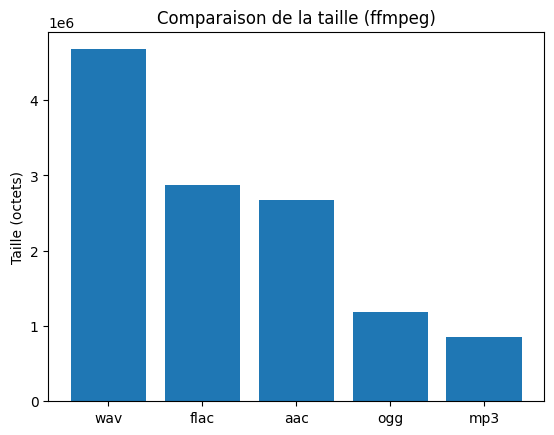

In [71]:
out()

On se rend bien compte que le FLAC est beaucoup plus efficace que le WAV en terme de compression, cependant, il est moins efficace que le MP3, l'OGG et l'AAC, bien que l'AAC soit un peu à la traîne par rapport au MP3 et à l'OGG. Mais bon je ne n'ai rien dis car je ne veux pas compromettre l'exposé de Quentin.

## 🎧 Qualité audio

1. **WAV** et **FLAC**: Qualité audio maximale.
2. **AAC**: Qualité audio très bonne.
3. **OGG**: Qualité audio bonne.
4. **MP3**: Qualité audio bonne.

Même chose que pour la compression, la qualité audio n'est pas un critère pertinent pour comparer un codec audio avec perte et sans perte.

Par ailleurs, l'évaluation de la qualité audio est subjective et dépend de l'oreille de chacun (le spectre auditif varie d'une personne à l'autre), de l'équipement audio utilisé et de l'environnement d'écoute. Car bien que sur le papier, on perd de l'information, si cette dernière est inaudible, alors cela n'a pas d'importance, et peut donc être considéré comme tout autre redondance et être éliminée.

## ⚒️ Usages

- **WAV**: Anciennement utilisé par les studios d'enregistrement.
- **FLAC**: Utilisé par les studios d'enregistrement, audio-philes, etc.
- **AAC**: Utilisé par Apple sur ses appareils.
- **OGG**: Utilisé pour les jeux vidéos, les vidéos, etc.
- **MP3**: Anciennement utilisé sur les CD, les baladeurs, etc.

Comme vous l'aurez compris, chaque format audio a ses propres avantages et inconvénients et est adapté à des usages spécifiques.

Ainsi pour une Mamie, le MP3 ou l'OGG seront amplement suffisant, même à de faibles débits.

Tandis que les studios d'enregistrement préféreront utiliser le FLAC afin d'économiser de l'espace disque sans perdre en qualité.

# 👏 Fin

Merci pour votre attention ! Cette présentation est maintenant terminée.


# 📚 Références

- Wikipedia : 
    - [FLAC](https://en.wikipedia.org/wiki/FLAC)
    - [Golomb-Rice Coding](https://en.wikipedia.org/wiki/Golomb_coding)
    - [Yule-Walker Equations](https://en.wikipedia.org/wiki/Autoregressive_model#Yule-Walker_equations)
    - [Levinson-Durbin Algorithm](https://en.wikipedia.org/wiki/Levinson_recursion)
    - [Audio File Formats](https://en.wikipedia.org/wiki/Audio_file_format)
    - [Comparison of Audio Formats](https://en.wikipedia.org/wiki/Comparison_of_audio_coding_formats)
    - [Audio Coding](https://en.wikipedia.org/wiki/Audio_coding_format)
    - [Audio Compression](https://en.wikipedia.org/wiki/Audio_compression_(data))

- Xiph.org :
    - [FLAC - Official Website](https://xiph.org/flac/)
    - [FLAC - Technical Documentation](https://xiph.org/flac/documentation_format_overview.html)
    - [FLAC - Format Specification](https://xiph.org/flac/format.html)
    - [FLAC - Source Code](https://gitlab.xiph.org/xiph/flac)
